# Model Evaluation 

## Agenda
1. Data Collection
2. Data Cleaning, Feature Engineering and Label Encoding
3. Model Evaluation
4. Data Prediction
5. Summary

# 1. Data Collection

**Import Required Packages**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import statistics
from sklearn.ensemble import VotingRegressor, StackingRegressor, RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge
from scipy.stats import randint, uniform, loguniform
import joblib
import os
import gc
import matplotlib.pyplot as plt

**Import the CSV Data as Pandas DataFrame**

In [2]:
start = time.time()
test = pd.read_csv("data/test.csv")
train = pd.read_csv("data/train.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")
print("Files loaded in", time.time()-start, "seconds")

Files loaded in 1.1763532161712646 seconds


# 2. Data Cleaning, Feature Engineering and Label Encoding

In [3]:
X_train = train.drop(['id', 'Listening_Time_minutes'], axis=1)
Y_train = train['Listening_Time_minutes']
X_test = test.drop('id', axis=1)

In [4]:
X_train['Number_of_Ads']=X_train['Number_of_Ads'].fillna(X_train['Number_of_Ads'].median())
X_train['Number_of_Ads'].isna().sum()

np.int64(0)

**Replacing nullable data in `Guest_Popularity_percentage` with 0**

In [5]:
X_train['Guest_Popularity_percentage']=X_train['Guest_Popularity_percentage'].fillna(0)
X_train['Guest_Popularity_percentage'].isna().sum()

np.int64(0)

In [6]:
X_test['Guest_Popularity_percentage']=X_test['Guest_Popularity_percentage'].fillna(0)
X_test['Guest_Popularity_percentage'].isna().sum()

np.int64(0)

**Using Simple Encoder**

In [7]:
imputer = SimpleImputer(strategy='median')
num_without_id = ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads']
X_train[num_without_id] = imputer.fit_transform(train[num_without_id])
print(f"Training data has been transformed")
X_test[num_without_id] = imputer.transform(test[num_without_id])
print(f"Testing data has been transformed")

Training data has been transformed
Testing data has been transformed


**Handling outliers**

In [8]:
def find_anomalies(data):
    anomalies=[]
    data_std = statistics.stdev(data)
    data_mean = statistics.mean(data)
    anomaly_cut_off = data_std * 3
    lower_limit = data_mean - anomaly_cut_off
    upper_limit = data_mean +anomaly_cut_off
    for outlier in data:
        if outlier > upper_limit or outlier < lower_limit:
            anomalies.append(outlier)
            print(f"The value of the outlier: {outlier}")
    return anomalies

def list_outliers(data, columns):
    anomalies = []
    for col in columns:
        outliers = find_anomalies(data[col])
        print(f"In the {col} column there are {len(outliers)} outliers")
        anomalies.append((col, outliers))
    return anomalies

In [9]:
print("Train outliers:")
train_anomalies = list_outliers(X_train, num_without_id)
print("Test outliers:")
test_anomalies = list_outliers(X_test, num_without_id)

Train outliers:
The value of the outlier: 325.24
In the Episode_Length_minutes column there are 1 outliers
In the Host_Popularity_percentage column there are 0 outliers
In the Guest_Popularity_percentage column there are 0 outliers
The value of the outlier: 53.37
The value of the outlier: 103.91
The value of the outlier: 103.0
The value of the outlier: 53.42
The value of the outlier: 103.75
The value of the outlier: 12.0
The value of the outlier: 103.25
The value of the outlier: 103.25
The value of the outlier: 103.88
In the Number_of_Ads column there are 9 outliers
Test outliers:
The value of the outlier: 78486264.0
In the Episode_Length_minutes column there are 1 outliers
In the Host_Popularity_percentage column there are 0 outliers
In the Guest_Popularity_percentage column there are 0 outliers
The value of the outlier: 89.12
The value of the outlier: 2063.0
In the Number_of_Ads column there are 2 outliers


In [10]:
def replace(data, value_up, value_low, columns):
    data_copy = data.copy()
    for column in columns:
        up_mask = data_copy[column] > value_up
        if up_mask.any():
            data_copy.loc[up_mask, column] = value_up
            print(f"{column}: replaced {up_mask.sum()} values with {value_up}")
        low_mask = data_copy[column] < value_low
        if low_mask.any():
            data_copy.loc[low_mask, column] = value_low
            print(f"{column}: replaced {low_mask.sum()} values with {value_low}")
    return data_copy

In [11]:
X_train_num = X_train[num_without_id]
X_test_num = X_test[num_without_id]
percentage_cols = ['Guest_Popularity_percentage', 'Host_Popularity_percentage']
X_train[num_without_id]= replace(X_train_num, 100,0,percentage_cols)
X_test[num_without_id] = replace(X_test_num, 100,0,percentage_cols)

Guest_Popularity_percentage: replaced 19 values with 100
Host_Popularity_percentage: replaced 25 values with 100
Guest_Popularity_percentage: replaced 5 values with 100
Host_Popularity_percentage: replaced 12 values with 100


In [12]:
def replace_outliers(train_data, test_data, columns):
    data_replaced_train = train_data.copy()
    data_replaced_test = test_data.copy()
    for column in columns:
        col_data_train = train_data[column]
        data_std = statistics.stdev(col_data_train)
        data_mean = statistics.mean(col_data_train)
        anomaly_cut_off = data_std * 3
        lower_limit = round(data_mean - anomaly_cut_off, 2)
        upper_limit = round(data_mean + anomaly_cut_off, 2)
        data_replaced_train = replace(data_replaced_train, upper_limit, lower_limit, [column])
        data_replaced_test = replace(data_replaced_test, upper_limit, lower_limit, [column])
    return data_replaced_train, data_replaced_test

In [13]:
outlier_cols = ['Episode_Length_minutes', 'Number_of_Ads']
X_train_replaced, X_test_replaced = replace_outliers(X_train, X_test, outlier_cols)
X_train_replaced = X_train_replaced.round({'Number_of_Ads':0})
X_test_replaced = X_test_replaced.round({'Number_of_Ads':0})
X_test = X_test_replaced
X_train = X_train_replaced

Episode_Length_minutes: replaced 1 values with 157.42
Episode_Length_minutes: replaced 2 values with 157.42
Number_of_Ads: replaced 9 values with 4.8
Number_of_Ads: replaced 2 values with 4.8


**`Episode_Title` to numerical column**

In [14]:
X_train['Episode_Title'] = X_train['Episode_Title'].str.extract('(\d+)').astype(int)
X_train['Episode_Title'].head()

0    98
1    26
2    16
3    45
4    86
Name: Episode_Title, dtype: int64

In [15]:
X_test['Episode_Title'] = X_test['Episode_Title'].str.extract('(\d+)').astype(int)
X_test['Episode_Title'].head()

0    73
1    23
2    11
3    73
4    50
Name: Episode_Title, dtype: int64

**Feature Engineering**

In [16]:
X_train['Ads_per_Popularity'] = X_train['Number_of_Ads'] / (X_train['Host_Popularity_percentage'] + 0.1)
X_test['Ads_per_Popularity'] = X_test['Number_of_Ads'] / (X_test['Host_Popularity_percentage'] + 0.1)
X_train['Length_Ads_Ratio'] = X_train['Episode_Length_minutes'] / (X_train['Number_of_Ads'] + 1)
X_test['Length_Ads_Ratio'] = X_test['Episode_Length_minutes'] / (X_test['Number_of_Ads'] + 1)
X_train['Length_Popularity_Interaction'] = X_train['Episode_Length_minutes'] * (X_train['Host_Popularity_percentage']+X_train['Guest_Popularity_percentage'])
X_test['Length_Popularity_Interaction'] = X_test['Episode_Length_minutes'] * (X_test['Host_Popularity_percentage']+X_test['Guest_Popularity_percentage'])

**Label Encoding**

In [17]:
ordinal_columns = ['Episode_Sentiment', 'Publication_Day', 'Publication_Time', 'Podcast_Name', 'Genre']

label_encoders = {}
for col in ordinal_columns:
    le = LabelEncoder()
    X_train[f'{col}_Encoded'] = le.fit_transform(X_train[col])
    X_test[f'{col}_Encoded'] = le.transform(X_test[col])
    label_encoders[col] = le
X_train = X_train.drop(ordinal_columns, axis=1)
X_test = X_test.drop(ordinal_columns, axis=1)

# 3. Model Choosing

Some features have very low correlation with target, so it is important to try not-linear models, such as:
1. Tree-Based Models
2. Gradient Boosting
3. Ensemble Methods

### 3.1 Splitting training set into validation and training sets

In [18]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=42
)

### 3.2 Choosing best parameters for the models and trying models that by the analysis are best for this project 

In [19]:
# np.random.seed(42)
# def create_and_validate(X_tr, y_tr):
#     param_grid_lgd = {
#         'n_estimators': randint(50,200),
#         'learning_rate': [0.05, 0.1, 0.2],
#         'max_depth': [7, 10, None],
#         'subsample': [0.8, 0.9]
#     }

#     param_grid_xgb = {
#         'n_estimators': randint(50,200),
#         'learning_rate': [0.05, 0.1, 0.2],
#         'max_depth': [7, 10, None],
#         'reg_lambda': [1, 5]
#     }

#     param_grid_cat = {
#         'iterations': randint(50,200),
#         'learning_rate': [0.05, 0.1, 0.2],
#         'depth': [8, 10, None],
#         'l2_leaf_reg': [3, 5]
#     }
#     lgb = LGBMRegressor(random_state=42, verbose=-1, n_jobs=1)
#     random_search_lgd = RandomizedSearchCV(
#         estimator=lgb,
#         param_distributions=param_grid_lgd,
#         n_iter=8,
#         cv=3,
#         n_jobs=-1,
#         verbose=1,
#         random_state=42,
#         return_train_score=True
#     )

#     random_search_lgd.fit(X_tr, y_tr)
#     best_params_lgd = random_search_lgd.best_params_
#     print("Best parameters for LGBMRegressor:", best_params_lgd)

#     xgb = XGBRegressor(random_state=42, n_jobs=1)

#     random_search_xgb = RandomizedSearchCV(
#         estimator=xgb,
#         param_distributions=param_grid_xgb,
#         n_iter=8,
#         cv=3,
#         n_jobs=-1,
#         random_state=42,
#         verbose=1,
#         return_train_score=True
#     )
#     random_search_xgb.fit(X_tr, y_tr)
#     best_params_xgb = random_search_xgb.best_params_
#     print("Best parameters for XGBRegressor:", best_params_xgb)


#     catboost = CatBoostRegressor(
#         random_seed=42,
#         verbose=False,
#         thread_count=-1
#     )

#     random_search_cat = RandomizedSearchCV(
#         estimator=catboost,
#         param_distributions=param_grid_cat,
#         n_iter=8,
#         cv=3,
#         n_jobs=1,
#         random_state=42,
#         verbose=1,
#         return_train_score=True
#     )
#     random_search_cat.fit(X_tr, y_tr)
#     best_params_cat = random_search_cat.best_params_
#     print("Best parameters for CatBoostRegressor:", best_params_cat)

#     param_dist = {
#         'n_estimators': randint(50, 200),
#         'max_depth': [10, 15, None],
#         'min_samples_split': randint(2, 10),
#         'max_features': ['sqrt', 'log2']
#     }

#     rf = RandomForestRegressor(random_state=42)
#     random_search = RandomizedSearchCV(
#         rf, param_dist, n_iter=8, cv=3,
#         n_jobs=-1, verbose=1, random_state=42
#     )
#     random_search.fit(X_tr, y_tr)
#     best_rf_params = random_search.best_params_
#     print(f'Best parameters for RandomForest: {best_rf_params}')

    
#     voting_ensemble = VotingRegressor([
#         ('lgb', LGBMRegressor(**best_params_lgd,
#             random_state=42
#         )),
#         ('xgb', XGBRegressor(**best_params_xgb,
#             random_state=42
#         )),
#         ('cat', CatBoostRegressor(**best_params_cat,
#             random_seed=42
#         )), 
#         ('rf', RandomForestRegressor(**best_rf_params,
#             random_state=42
#         ))
#     ])
#     stacking_ensemble = StackingRegressor([
#         ('lgb', LGBMRegressor(**best_params_lgd,
#             random_state=42
#         )),
#         ('xgb', XGBRegressor(**best_params_xgb,
#             random_state=42
#         )),
#         ('cat', CatBoostRegressor(**best_params_cat,
#             random_seed=42
#         )), 
#         ('rf', RandomForestRegressor(**best_rf_params,
#             random_state=42
#         ))
#     ], final_estimator=Ridge(alpha=1.0), cv=3)
    
    
#     models = {
#         'LightGBM': LGBMRegressor(**best_params_lgd, random_state=42),
#         'XGBoost': XGBRegressor(**best_params_xgb, random_state=42),
#         'CatBoost': CatBoostRegressor(**best_params_cat, random_state=42),
#         'RandomForest': RandomForestRegressor(**best_rf_params, random_state=42),
#         'Voting_Ensemble': voting_ensemble,
#         'Stacking_Ensemble': stacking_ensemble,
#     }
#     return models, best_params_lgd, best_params_xgb, best_params_cat, best_rf_params

# models, best_params_lgd, best_params_xgb, best_params_cat, best_rf_params = create_and_validate(X_tr, y_tr)

In [20]:
# def train_and_evaluate_models(models, X_tr, y_tr, X_val, y_val):
#     results = {}
#     rmse_values = []
#     model_names = []
    
#     for name, model in models.items():
#         print(f"\n--- MODEL TRAINING {name} ---")
        
#         model.fit(X_tr, y_tr)
        
#         y_pred = model.predict(X_val)
#         rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        
#         results[name] = {
#             'model': model,
#             'rmse': rmse,
#             'predictions': y_pred
#         }
        
#         rmse_values.append(rmse)
#         model_names.append(name)
        
#         print(f"RMSE: {rmse:.4f}")
    
#     plt.figure(figsize=(10, 6))
#     bars = plt.bar(model_names, rmse_values, color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
#     plt.title('Model Comparison (RMSE)', fontsize=14, fontweight='bold')
#     plt.ylabel('RMSE Score', fontsize=12)
#     plt.xticks(rotation=45)
    
#     for bar, value in zip(bars, rmse_values):
#         plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
#                 f'{value:.4f}', ha='center', va='bottom', fontweight='bold')
    
#     plt.tight_layout()
#     plt.show()
    
#     return results

# results = train_and_evaluate_models(models, X_tr, X_val, y_tr, y_val)

#### Insights:
The best RMSE has RandomForestRegressor with certain parameters, so let's try to improve its performance

In [21]:
# np.random.seed(42)
# def create_and_validate_forests(X_tr, X_val, y_tr, y_val, best_rf_params):
#     forests = [
#         RandomForestRegressor(**best_rf_params, random_state=i, n_jobs=-1)
#         for i in range(5)
#     ]

#     individual_preds = []
#     for i, forest in enumerate(forests):
#         forest.fit(X_tr, y_tr)
#         pred = forest.predict(X_val)
#         individual_preds.append(pred)
#         print(f"Forest {i+1} trained")

#     preds = np.mean(individual_preds, axis=0)
#     rmse = np.sqrt(mean_squared_error(y_val, preds))

#     plt.figure(figsize=(12, 6))
#     for i, pred in enumerate(individual_preds):
#         plt.scatter(y_val, pred, alpha=0.6, label=f'Forest {i+1}', s=30)
    
#     plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', alpha=0.8)
#     plt.xlabel('True Values')
#     plt.ylabel('Predicted Values')
#     plt.title(f'Individual Forest Predictions vs True Values\nEnsemble RMSE: {rmse:.4f}')
#     plt.legend()
#     plt.grid(True, alpha=0.3)
#     plt.show()

#     print("RMSE:", rmse)
#     return forests, preds, individual_preds

# forests, preds = create_and_validate_forests(X_tr, y_tr)

#### Insights:
This model performs better than others, but the main issues are optimization and high memory usage. Increasing the number of forests will likely cause a memory error.

#### We can try BaggingRegressor as it creates many "weaker" models on different data samples and averages their predictions to get a more robust final prediction.

In [22]:
# def create_and_validate_forests_bagging(X_tr, X_val, y_tr, y_val): 
#     bagging = BaggingRegressor(
#         RandomForestRegressor(max_depth=None, max_features='log2', min_samples_split=4),
#         n_estimators=10,
#         max_samples=0.8,
#         random_state=42
#     )

#     bagging.fit(X_tr, y_tr)
#     preds = bagging.predict(X_val) 
#     rmse = np.sqrt(mean_squared_error(y_val, preds))

#     plt.figure(figsize=(10, 6))
#     plt.scatter(y_val, preds, alpha=0.6, s=50, color='blue')
#     plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', linewidth=2)
#     plt.xlabel('True Values')
#     plt.ylabel('Predicted Values')
#     plt.title(f'BaggingRegressor Predictions\nRMSE: {rmse:.4f}')
#     plt.grid(True, alpha=0.3)
#     plt.show()

#     print("RMSE:", rmse)
#     return bagging, preds
# bagging, preds = create_and_validate_forests_bagging(X_tr, X_val, y_tr, y_val)

### Insights:
It is not so good, as the previous model, so we can optimize memory usage by saving each model to disk and loading them only when needed for predictions.

In [23]:
models_dir = "saved_models"
os.makedirs(models_dir, exist_ok=True)

In [ ]:
models_dir = "saved_models"
os.makedirs(MODELS_DIR, exist_ok=True)

def predict_from_disk(models_dir, X_val, y_val, best_params):
    predictions = []
    model_files = []
    
    for file in os.listdir(models_dir):
        if file.startswith('') and file.endswith('.joblib'):
            model_files.append(file)
    
    model_files.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))
    
    for i, file in enumerate(model_files):
        forest = joblib.load(os.path.join(models_dir, file))
        
        pred = forest.predict(X_val)
        predictions.append(pred)
        
        print(f"Model {i+1} predicted")
        
        del forest
        gc.collect()
    
    final_prediction = np.mean(predictions, axis=0)
    
    rmse = np.sqrt(mean_squared_error(y_val, final_prediction))
    
    print(f"Final RMSE: {rmse:.4f}")
    return final_prediction, rmse

def create_and_validate_forests_disk(X_tr, X_val, y_tr, y_val, models_dir):
    os.makedirs(models_dir, exist_ok=True)
    for i in range(30):
        forest = (**best_params, random_state=i, n_jobs=3)

        forest.fit(X_tr, y_tr)
        
        filename = f'{models_dir}/{i}.joblib'
        joblib.dump(, filename)
        
        joblib.load(filename)
        del forest
        gc.collect()
        print(f" {i+1} trained and saved")
    final_pred, rmse = predict_from_disk(models_dir, X_val, y_val)
    return models_dir, rmse
create_and_validate_forests_disk(X_tr, X_val, y_tr, y_val, models_dir, best_rf_params)

# 4. Data Prediction

Model 1 predicted - Ensemble size: 1
Model 2 predicted - Ensemble size: 2
Model 3 predicted - Ensemble size: 3
Model 4 predicted - Ensemble size: 4
Model 5 predicted - Ensemble size: 5
Model 6 predicted - Ensemble size: 6
Model 7 predicted - Ensemble size: 7
Model 8 predicted - Ensemble size: 8
Model 9 predicted - Ensemble size: 9
Model 10 predicted - Ensemble size: 10
Model 11 predicted - Ensemble size: 11
Model 12 predicted - Ensemble size: 12
Model 13 predicted - Ensemble size: 13
Model 14 predicted - Ensemble size: 14
Model 15 predicted - Ensemble size: 15
Model 16 predicted - Ensemble size: 16
Model 17 predicted - Ensemble size: 17
Model 18 predicted - Ensemble size: 18
Model 19 predicted - Ensemble size: 19
Model 20 predicted - Ensemble size: 20
Model 21 predicted - Ensemble size: 21
Model 22 predicted - Ensemble size: 22
Model 23 predicted - Ensemble size: 23
Model 24 predicted - Ensemble size: 24
Model 25 predicted - Ensemble size: 25
Model 26 predicted - Ensemble size: 26
Mode

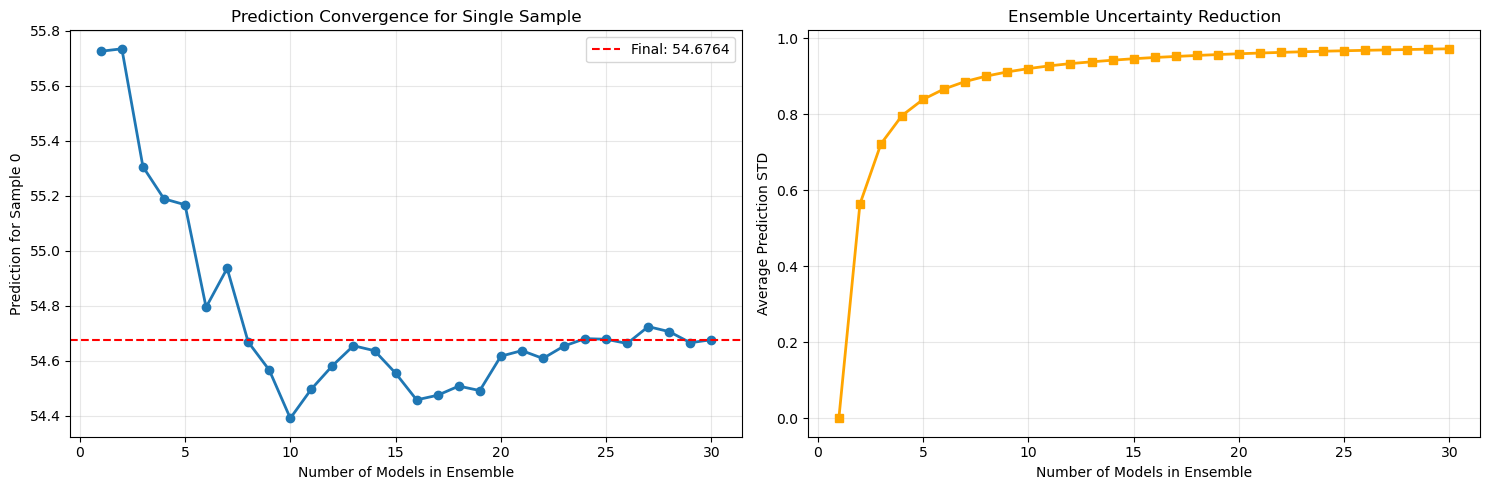

In [25]:
def predict_from_disk_test(models_dir, X_test, X_train, Y_train):
    predictions = []
    model_files = []
    prediction_means = []
    prediction_stds = []
    
    for file in os.listdir(models_dir):
        if file.startswith('forest_') and file.endswith('.joblib'):
            model_files.append(file)
    
    model_files.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))
    
    for i, file in enumerate(model_files):
        forest = joblib.load(os.path.join(models_dir, file))
        forest.fit(X_train, Y_train)
        pred = forest.predict(X_test)
        predictions.append(pred)
        
        current_ensemble = np.mean(predictions, axis=0)
        current_std = np.std(predictions, axis=0)
        
        prediction_means.append(current_ensemble)
        prediction_stds.append(current_std)
        
        print(f"Model {i+1} predicted - Ensemble size: {len(predictions)}")
        
        del forest
        gc.collect()
    
    final_prediction = np.mean(predictions, axis=0)
    
    plt.figure(figsize=(15, 5))
    
    # Average prediction
    plt.subplot(1, 2, 1)
    sample_idx = 0
    ensemble_progress = [pred_mean[sample_idx] for pred_mean in prediction_means]
    plt.plot(range(1, len(ensemble_progress) + 1), ensemble_progress, 'o-', linewidth=2)
    plt.axhline(y=final_prediction[sample_idx], color='red', linestyle='--', 
                label=f'Final: {final_prediction[sample_idx]:.4f}')
    plt.xlabel('Number of Models in Ensemble')
    plt.ylabel(f'Prediction for Sample {sample_idx}')
    plt.title('Prediction Convergence for Single Sample')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Standard devation
    plt.subplot(1, 2, 2)
    mean_stds = [np.mean(pred_std) for pred_std in prediction_stds]
    plt.plot(range(1, len(mean_stds) + 1), mean_stds, 's-', color='orange', linewidth=2)
    plt.xlabel('Number of Models in Ensemble')
    plt.ylabel('Average Prediction STD')
    plt.title('Ensemble Uncertainty Reduction')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
        
    return final_prediction
prediction = predict_from_disk_test(models_dir, X_test, X_train, Y_train)

### Saving predictions

In [27]:

results = pd.DataFrame({
        'id': range(750000, 750000 + len(prediction)),
        'Listening_Time_minutes': prediction
})

results.to_csv('data/sample_submission.csv', index=False, float_format='%.3f')
print("Predictions were saved in predictions.csv")

Predictions were saved in predictions.csv


# 5. Summary

We have experimented with several advanced machine learning models including LGBMRegressor, XGBRegressor, CatBoostRegressor, and RandomForestRegressor, with hyperparameter optimization performed using RandomizedSearchCV to identify the optimal configuration for each algorithm. Additionally, we implemented Voting and Stacking ensembles to leverage the strengths of multiple models.

Surprisingly, the best performance was achieved by RandomForestRegressor with specific tuned parameters, despite competing against more complex gradient boosting alternatives.

The primary challenge we faced was model optimization and performance enhancement, as we frequently encountered memory limitations during training. This issue was particularly pronounced with RandomForestRegressor due to its inherent nature as a computationally intensive ensemble method that builds multiple decision trees in parallel.

To address these memory constraints and ensure scalable deployment, we implemented a disk-based model persistence strategy. This approach involves:

- Saving trained models to disk storage

- Loading models on-demand for prediction tasks

- Reducing in-memory footprint during inference

This solution not only resolves the memory issues but also enables model portability and facilitates deployment in resource-constrained environments while maintaining prediction accuracy.